## Regression with BIWI head pose dataset

This is a more advanced example to show how to create custom datasets and do regression with images. Our task is to find the center of the head in each image. The data comes from the [BIWI head pose dataset](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db), thanks to Gabriele Fanelli et al. We have converted the images to jpeg format, so you should download the converted dataset from [this link](https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose.tgz).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

## Getting and converting the data

In [15]:
path = untar_data(URLs.BIWI_HEAD_POSE)
path

PosixPath('/home/jupyter/.fastai/data/biwi_head_pose')

In [14]:
path.ls()[:3]

[PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/24.obj'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/03'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/17.obj')]

In each folder number there are frames of a video per individual person. What does the data look like?

A .cal file is device calibration information. This is ASCII text. [More info on cal files](https://www.argyllcms.com/doc/cal_format.html)

In [16]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [18]:
fname = '09/frame_00667_rgb.jpg'

In [29]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

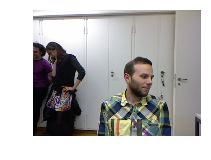

In [30]:
img = open_image(path/fname)
img.show()

In [31]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([187.332 ,  40.3892, 893.135 ])

the coords are the ctr variable, see array above. 
the cal is the calibration file

In [44]:
def convert_biwi(coords):
    #print(cal)
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    #print(ctr)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [45]:
get_ctr(fname)

tensor([263.9104, 428.5814])

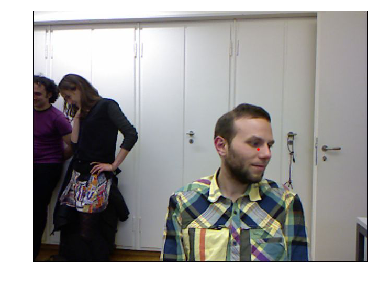

In [46]:
ctr = get_ctr(fname)
#show image with image point
img.show(y=get_ip(img, ctr), figsize=(6, 6))

## Creating a dataset

Training a neural net to find the centre point of a person face. 

In [47]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

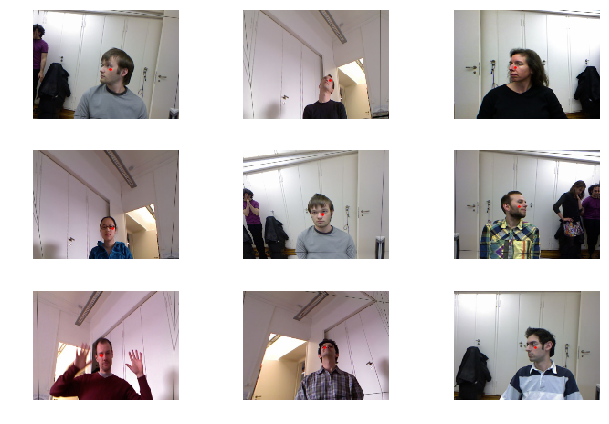

In [48]:
data.show_batch(3, figsize=(9,6))

## Train model

In [49]:
learn = create_cnn(data, models.resnet34)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


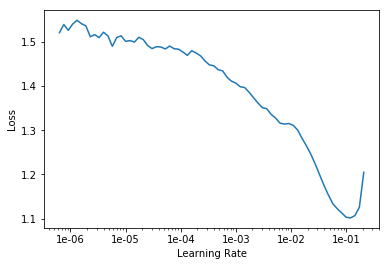

In [50]:
learn.lr_find()
learn.recorder.plot()

In [51]:
lr = 2e-2

In [52]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss
1,0.048581,0.004201
2,0.018074,0.009151
3,0.008854,0.002535
4,0.005350,0.001527
5,0.003961,0.000727


In [53]:
learn.save('stage-1')

In [54]:
learn.load('stage-1');

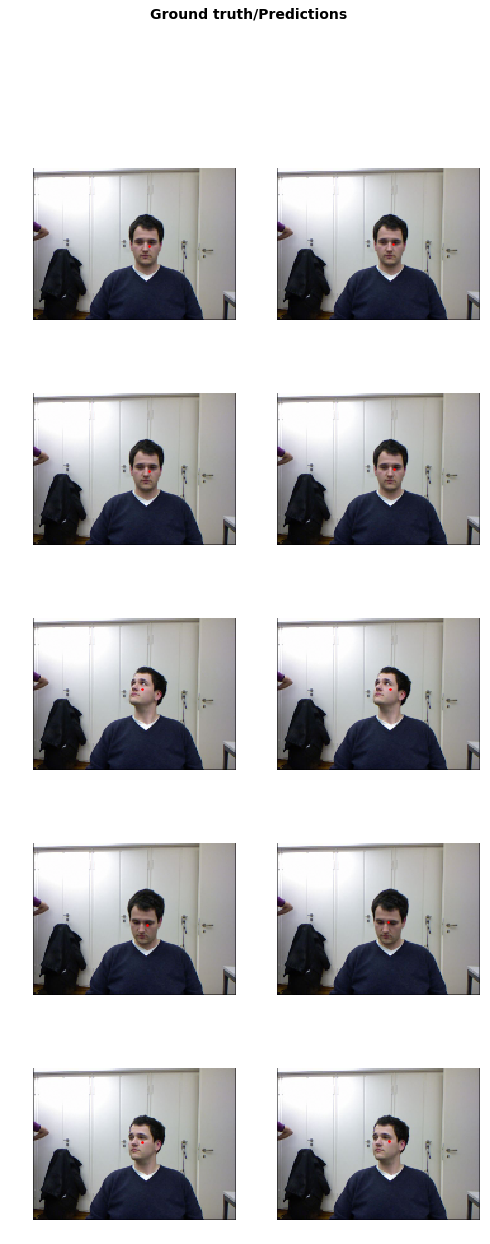

In [55]:
learn.show_results()

## Data augmentation

In [56]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

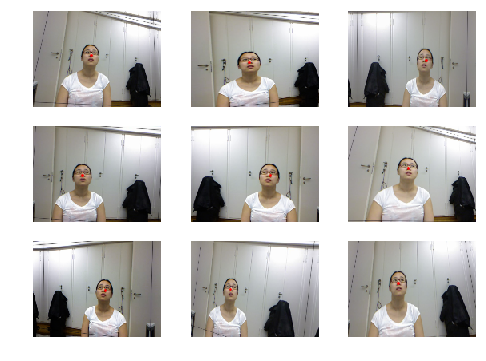

In [57]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,6))